In [1]:
import pandas as pd

df = pd.read_csv("data/german_credit.csv")

In [9]:
df.shape

(1000, 21)

## Data Cleaning Pipeline

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

cat_attribs = ['status', 'credit_history', 'purpose', 'savings', 'property', 'job',
                'other_debtors', 'other_installment_plans', 'housing', 'people_liable', 'telephone', 'foreign_worker']

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

In [3]:
ordinal_columns = ['employment_duration', 'installment_rate', 'present_residence', 'number_credits']

categories_dict = {
    'employment_duration': ['unemployed', '< 1 yr', '1 <= ... < 4 yrs', '4 <= ... < 7 yrs', '>= 7 yrs'],
    'installment_rate': ['< 20', '20 <= ... < 25', '25 <= ... < 35', '>= 35'],
    'present_residence': ['< 1 yr', '1 <= ... < 4 yrs', '4 <= ... < 7 yrs', '>= 7 yrs'],
    'number_credits': ['1', '3-Feb', '5-Apr', '>= 6']
}

In [4]:
from sklearn.preprocessing import OrdinalEncoder

ord_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=[categories_dict[col] for col in ordinal_columns]))

In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
import numpy as np

def column_ratio(X):
    X = np.array(X)
    ratio = X[:, 0] / X[:, 1]
    return ratio.reshape(-1, 1)

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

preprocessing = ColumnTransformer([
        ("annual_amount", ratio_pipeline(), ["amount", "duration"]),
        ("log", log_pipeline, ["amount", "duration", "age"]),
        ("cat", cat_pipeline, cat_attribs),
        ("ord", ord_pipeline, ordinal_columns),
        ("drop_personal_status_sex", "drop", ["personal_status_sex"]) ,
    ],
    remainder='passthrough')

In [7]:
credit_prepared = preprocessing.fit_transform(df)
credit_prepared.shape

(1000, 56)

In [12]:
feature_names = preprocessing.get_feature_names_out()

credit = pd.DataFrame(credit_prepared, columns=feature_names)
credit = credit.drop('remainder__credit_risk', axis=1)
credit.head()

,annual_amount__ratio,log__amount,log__duration,log__age,cat__status_... < 0 DM,cat__status_... >= 200 DM / salary for at least 1 year,cat__status_0<= ... < 200 DM,cat__status_no checking account,cat__credit_history_all credits at this bank paid back duly,cat__credit_history_critical account/other credits elsewhere,...,cat__people_liable_0 to 2,cat__people_liable_3 or more,cat__telephone_no,cat__telephone_yes (under customer name),cat__foreign_worker_no,cat__foreign_worker_yes,ord__employment_duration,ord__installment_rate,ord__present_residence,ord__number_credits
0,-0.713147,-1.073386,0.022947,-1.604694,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0
1,0.934161,0.191138,-1.168132,0.197788,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,2.0,2.0,1.0,1.0
2,-0.636195,-1.358137,-0.67379,-1.300472,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,3.0,2.0,3.0,0.0
3,0.059628,-0.16564,-0.67379,0.465462,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0
4,0.086245,-0.136226,-0.67379,0.378596,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,3.0,1.0


## K-Means

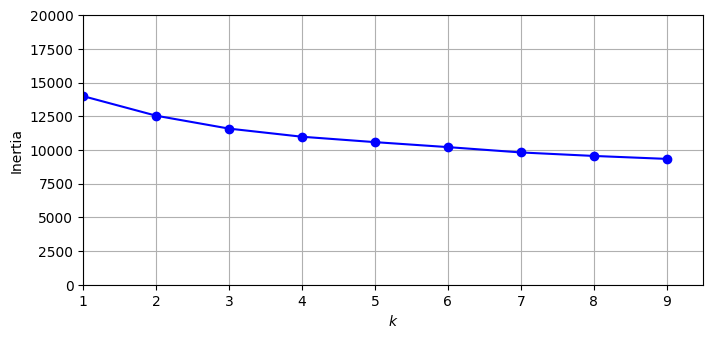

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

kmeans_per_k = [KMeans(n_clusters=k, n_init=30, random_state=42).fit(credit)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.axis([1, 9.5, 0, 20000])
plt.grid()
plt.show()

In [18]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_values = range(2, 6)  # Evaluate from 1 to 5 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=30, random_state=42)
    labels = kmeans.fit_predict(credit)
    score = silhouette_score(credit, labels)
    silhouette_scores.append(score)

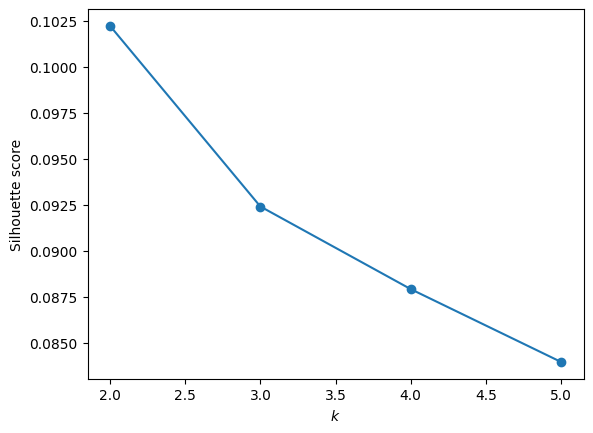

In [19]:
import matplotlib.pyplot as plt

plt.plot(k_values, silhouette_scores, marker='o', linestyle='-')
plt.xlabel('$k$')
plt.ylabel('Silhouette score')
plt.show()

In [20]:
kmeans = KMeans(n_clusters=2, n_init=30, random_state=42)
labels = kmeans.fit_predict(credit)

In [35]:
credit['cluster'] = labels

In [36]:
credit['credit_risk'] = df['credit_risk']

In [37]:
credit.head()

,annual_amount__ratio,log__amount,log__duration,log__age,cat__status_... < 0 DM,cat__status_... >= 200 DM / salary for at least 1 year,cat__status_0<= ... < 200 DM,cat__status_no checking account,cat__credit_history_all credits at this bank paid back duly,cat__credit_history_critical account/other credits elsewhere,...,cat__telephone_no,cat__telephone_yes (under customer name),cat__foreign_worker_no,cat__foreign_worker_yes,ord__employment_duration,ord__installment_rate,ord__present_residence,ord__number_credits,cluster,credit_risk
0,-0.713147,-1.073386,0.022947,-1.604694,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,1,good
1,0.934161,0.191138,-1.168132,0.197788,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,2.0,2.0,1.0,1.0,1,good
2,-0.636195,-1.358137,-0.67379,-1.300472,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,3.0,2.0,3.0,0.0,1,good
3,0.059628,-0.16564,-0.67379,0.465462,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,1,good
4,0.086245,-0.136226,-0.67379,0.378596,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,2.0,0.0,3.0,1.0,0,good


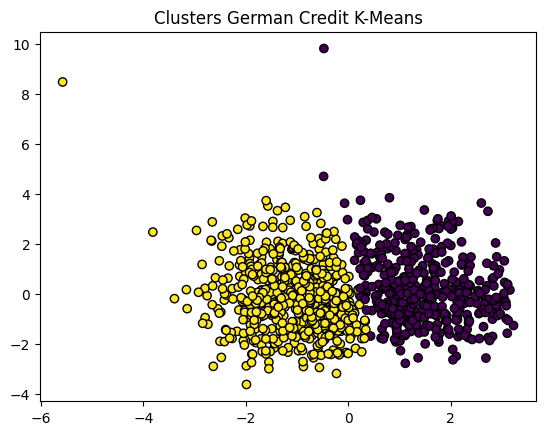

In [38]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X = credit.drop(['credit_risk'], axis=1))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=credit["cluster"], cmap="viridis", edgecolors="k")
plt.title("Clusters German Credit K-Means")
plt.show()

In [40]:
pd.crosstab(credit["cluster"], credit["credit_risk"], normalize="index")

credit_risk,bad,good
cluster,,
0,0.250597,0.749403
1,0.335628,0.664372


## DBSCAN